In [2]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [3]:

import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [4]:
def load_img_dict(target_x,target_y,debug=True):
    possible_f_num = ['F01','F02','F04','F08','F16','F32']
    x_f_num = []
    if target_x == 'F#':
        for f_num in possible_f_num:
            if f_num != target_y:
                x_f_num.append(f_num)
            else :
                break
    else :
        x_f_num = [target_x]
    print(x_f_num)
    img_dict = {}
    path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung_SNU",
                 "/home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung+SNU+dataset+221115"
                 ]
    # data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 
    debug = True
    for data_path in path_list:
        print("=====",data_path, "=====")
        for set_num in sorted(os.listdir(data_path)):
            if set_num[0] == '.' :
                continue
            set_path = os.path.join(data_path,set_num)
            set_number = set_num.split(" ")[-1][:-1]
            set_num = f"{set_num[1:4]}{set_number}"
            print("=====",set_num, "=====")
            img_dict[set_num] = {}
            # if debug is True:
            #     print(set_num)
            f_num_list = os.listdir(set_path)
            # print(f_num_list)
            for f_num in f_num_list:
                f_path = os.path.join(set_path,f_num)
                f_number = int(f_num[1:])
                f_num = f"F{f_number:02d}"
                # print(set_num,f_num)
                if f_num not in x_f_num:
                    continue
                # img_dict[set_num][f_num] = None
                img_dict[set_num][f_num] = {}
                img_list = sorted(os.listdir(f_path))
                img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
                
                for filename in sorted(img_list):
                    
                    img_path = os.path.join(f_path,filename)
                    image_idx = int(filename.split("_")[0])
                    filename = f"{set_num}_{f_num}_{image_idx:02d}.png"
                    if debug is True:
                        print(f_num," & ",filename)
                    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) 
                    # img_dict[set_num][f_num].append(img)
                    # img = np.expand_dims(img,axis=0)
                    img = np.expand_dims(img,axis=0) / 255.
                    img_dict[set_num][f_num][filename] = img
                    # if img_dict[set_num][f_num] is None:  
                    #     img_dict[set_num][f_num] = img
                    # else :
                    #     img_dict[set_num][f_num] = np.append(img_dict[set_num][f_num],img,axis=0)
                    if debug is True:
                        print(set_num,f_num,img.shape)
    if debug is True:
        print(img_dict.keys())
        for set_num in img_dict.keys():
            print(" ",img_dict[set_num].keys())
            for f_num in img_dict[set_num].keys():
                print("   ",img_dict[set_num][f_num].keys())
    print("====== load img_dict complete ======")
    return img_dict
                        

In [5]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [6]:
!date
!ls -alh ../weights/23*F08*F64*

Wed Jul  5 02:36:45 UTC 2023
-rw-rw-r-- 1 hyunwoong hyunwoong 3.2M Apr  9 10:10 ../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
-rw-rw-r-- 1 hyunwoong hyunwoong 3.2M Jun  6 15:18 ../weights/230530_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
-rw-rw-r-- 1 hyunwoong hyunwoong 3.2M Jun  5 17:18 ../weights/230530_find_lambda_FBI_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_x_as_F08_y_as_F64_l1_on_img_gradient_0.005_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_256.w
-rw-rw-r-- 1 hyunwoong hyunwoong 3.2M Jun  1 07:29 ../weights/230530_find_lambda_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F08_y_as_F64_l1_on_img_gradient_0.005_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_256.w


In [7]:
gc.collect()
debug= True
#  '../weights/230303_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w'
# for fbi_weight_dir in sorted(glob("../weights/230207_FBI_Net*")):
# target_fbi_weight = [ #"../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_ with_SET01020304individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
                    #  "../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_mixed_x_as_F#_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
                        # "../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
#                       #"../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_mixed_x_as_F#_y_as_F16_median_filter_input_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
#                       '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_mixed_x_as_F#_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
                     # ]
# 230331
# target_fbi_weight = [
    # '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F02_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # "../weights/230228_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
# "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",

# "../weights/230303_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F02_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
# "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",

# "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F04_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",

# "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
# "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F02_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
# ]
# 230406
# target_fbi_weight = [
#          '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
#          '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F02_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
#          '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F04_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
#          '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
#          '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F16_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w'
# ]
# 230410
# target_fbi_weight = [
    # '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F01_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w', 
    
    # '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # '../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # '../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # '../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    
    # '../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_median_filter_target_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # '../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F32_median_filter_target_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
# ]
# 230609 check F#-F8 vs F1-F8
target_fbi_weight = [
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
]


====== F01 vs F08 v2 is_apply_median_input :  False  ======
../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
folder_name :  ./denoised_img_F01_vs_F08_v2
['F01']
===== /home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung_SNU =====
===== SET1 =====
===== SET2 =====
===== SET3 =====
===== SET4 =====
===== /home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung+SNU+dataset+221115 =====
===== SET10 =====
F01  &  SET10_F01_01.png
SET10 F01 (1, 2048, 3072)
F01  &  SET10_F01_02.png
SET10 F01 (1, 2048, 3072)
===== SET5 =====
F01  &  SET5_F01_01.png
SET5 F01 (1, 2048, 3072)
F01  &  SET5_F01_02.png
SET5 F01 (1, 2048, 3072)
===== SET6 =====
F01  &  SET6_F01_01.png
SET6 F01 (1, 2048, 3072)
F01  &  SET6_F01_02.png
SET6 F01 (1, 2048, 3072)
===== SET7 =====
F01  &  SET7_F01_01.png
SET7 F01 (1, 2048, 3072)
F01  &  SET7_F01_02.png
SET7 F01 (1, 2048, 3072)
===== SET8 =====
F01  &  SET8_F01_01.png
SET8 F

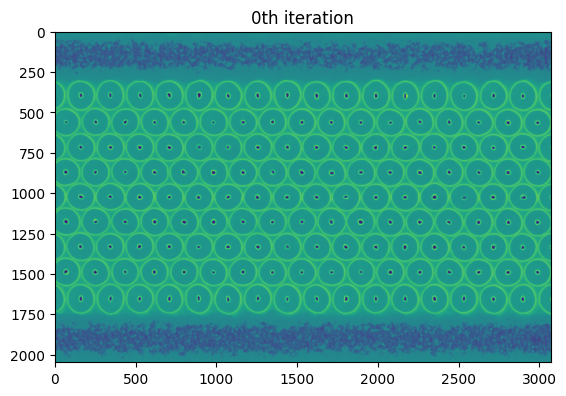

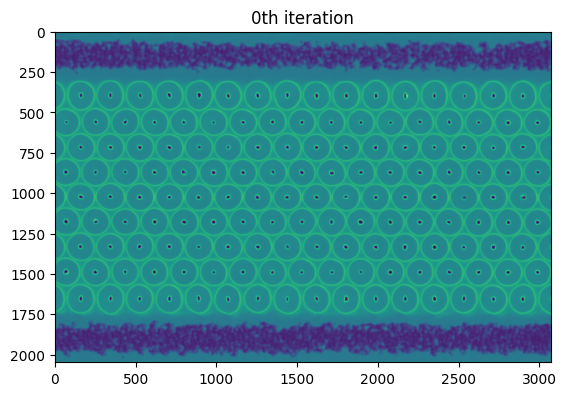

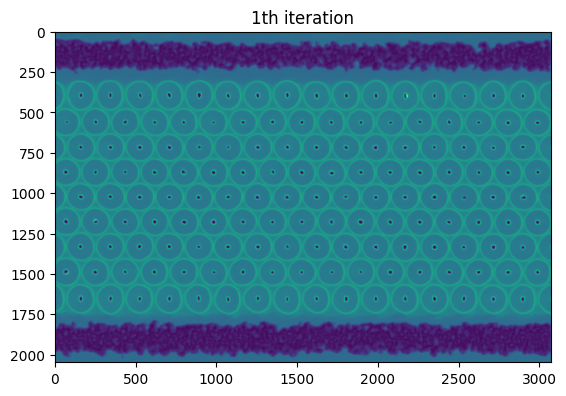

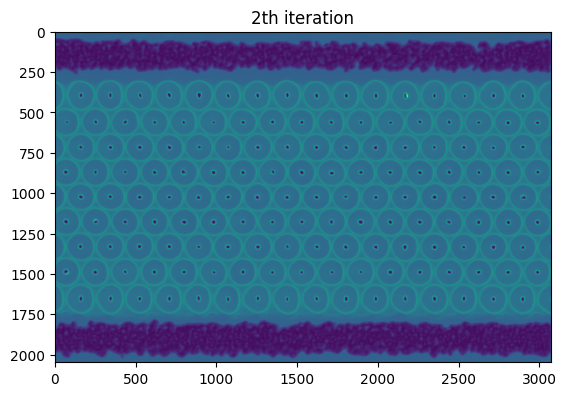

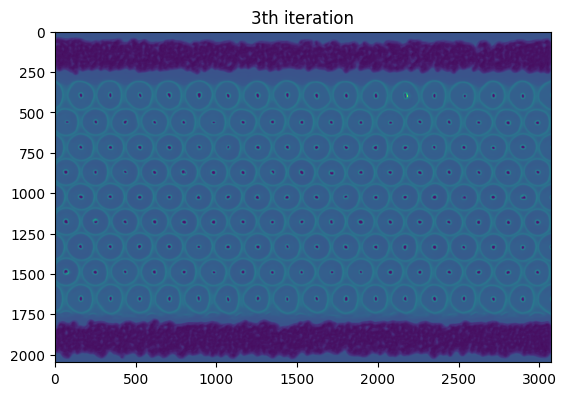

SystemExit: 0

/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:

for fbi_weight_dir in target_fbi_weight:
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("_x_as_")[1][:3]
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    
    dataset_version = 'v1' if "with" in fbi_weight_dir else 'v2'
    is_apply_median_input = True if "median_filter_input" in fbi_weight_dir else False
    is_apply_median_target = True if "median_filter_target" in fbi_weight_dir else False
    # if target_y not in ['F08','F16']:
    #     continue
    print("======",target_x,"vs",target_y,dataset_version,"is_apply_median_input : " , is_apply_median_input," ======")
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    folder_name = f"./denoised_img_{target_x}_vs_{target_y}_{dataset_version}"
    if is_apply_median_input is True:
        folder_name += "_median_filter_input"
    if is_apply_median_target is True:
        folder_name += 'median_filter_target'
        # folder_name += "_median_filter_input_but_not_used_at_inference"
    print("folder_name : ",folder_name)
    os.makedirs(folder_name,exist_ok=True)
    if target_x == 'F#':
        img_dict = load_img_dict('F01',target_y,debug=True)
    else :
        img_dict = load_img_dict(target_x,target_y,debug=True)
    
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    denoised_img_dict = {}
    for set_num in img_dict.keys():
        denoised_img_dict[set_num] = {}
        for f_num in img_dict[set_num].keys():
            denoised_img_dict[set_num][f_num] = None
            if f_num != target_x and target_x != 'F#':
                continue
            for idx,(filename, img) in enumerate(img_dict[set_num][f_num].items()):
                img = np.expand_dims(img, axis=0) # 1,1536x3074
                print(filename,set_num,f_num,idx,img.shape)
                if is_apply_median_input is True:
                    img = apply_median_filter_gpu_simple(img)
                denoised_img = model.eval(img)[0]
                
                # print("after denoised",denoised_img.shape)
                if denoised_img_dict[set_num][f_num] is None:
                    denoised_img_dict[set_num][f_num] = denoised_img
                else :
                    denoised_img_dict[set_num][f_num] = np.append(denoised_img_dict[set_num][f_num], denoised_img,axis=0)
                # filename = f"{set_num}_{f_num}_{idx}.png"
                # if os.path.isfile(f"{folder_name}/{filename}"):
                #     print("already exist : ",f"{folder_name}/{filename}")
                #     continue
                # else :
                #     print("imwrite : ",f"{folder_name}/{filename}")
                #     cv2.imwrite(f"{folder_name}/{filename}",denoised_img[0]*255)
                print("imwrite : ",f"{folder_name}/{filename}")
                cv2.imwrite(f"{folder_name}/{filename}",denoised_img[0]*255)
                
            print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            
    # np.save(f"./intermediate_result/{folder_name}_denoised_img_dict.npy",denoised_img_dict)
    import zipfile



    zip_file = zipfile.ZipFile(folder_name + ".zip", "w")  # "w": write 모드
    for file in os.listdir(folder_name):
        if file.endswith('.png'):
            zip_file.write(os.path.join(folder_name, file), compress_type=zipfile.ZIP_DEFLATED)

    zip_file.close()
    gc.collect()


In [ ]:
folder_name

'./denoised_img_F#_vs_F08_v2'